## Make spike/burst waveform visualization for manuscript Fig 2

## Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os 
import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import rcParams
from sklearn.neighbors import KernelDensity
    
from mosquito.process_abf import load_processed_data, detrend_emg
from mosquito.util import set_plot_params, my_adjust_axes, my_add_scalebar
from mosquito.analyze_bursts import run_spike_detection


## Helper functions

In [15]:
def plot_data_trace(data, key, time_range, channel=0, ax=None, scalebar_size=1, ylim=None,
                   time_units='s', fig_params=None, line_color='k'):
    """
    Function to take in a data dictionary for a single fly and make
    a zoomed-out plot of the time series data trace in 'key'

    Args:
        - data: dictionary loaded from pickled *_processed.p file
        - key: string, giving data dict key for variable to plot
        - channel: if plotting multichannel data, give channel number
        - time_window: tuple giving the range of data to plot 
            (e.g. (4, 8) will plot between t=4 and t=8 seconds)
        - ax: axis object to plot to
        - scalebar_size: size (duration) of scalebar, in seconds
        - figsize: tuple giving (width, height) of figure in inches 
            (passed to pyplot.subplots)
        - ylim: tuple giving y axis limits. If None, use auto scale
        - time_units: units of time values in data. should be 's'
        - fig_params: dictionary containing plot params; under 
            construction

    Returns:
        - fig, ax
    """
    # read out data from dict
    t = data['time']
    dat = data[key]

    if isinstance(dat, list):
        dat = dat[channel]
        
    if key == 'emg':
        dat = detrend_emg(dat)

    # plot params
    # TODO: move this to params dictionary
    linewidth = 0.5 
    scalebar_linewidth = 1.0  # 1.5
    color = line_color
    
    # initialize figure (if needed)
    if ax is None:
        fig, ax = plt.subplots()

    # restrict time domain to time_range
    mask = (t >= time_range[0]) & (t <= time_range[-1])

    dat_curr = dat[mask]
    t_curr = t[mask]
    
    # plot. Note that we're subtracting off the initial time so it always
    # starts at t=0
    ax.plot(t_curr - time_range[0],
             dat_curr,
             color=color,
             lw=linewidth)

    # -----------------------------------------
    # axis properties
    # restrict x range
    ax.set_xlim([0, time_range[1] - time_range[0]])

    # restrict y range?
    if ylim is not None:
        ax.set_ylim(ylim)
        
    # add scalebar
    ax.spines['bottom'].set_bounds([0, scalebar_size])
    ax.spines['bottom'].set_linewidth(scalebar_linewidth)
    ax.spines['bottom'].set_position(('outward', 3))

    # label scalebar. 
    ax.set_xticks([scalebar_size/2])
    ax.set_xticklabels([f'{scalebar_size} {time_units}'])
    ax.tick_params(length=0)
    
    # remove other axis lines
    for spine in ['right', 'top', 'left']:
        ax.spines[spine].set_visible(False)

    # remove y ticks
    ax.set_yticks([])
    
    return ax


In [16]:
def make_burst_spike_figure(ax, t, time_range, spike_idx_all, line_width=1, line_color='k', line_height=1, 
                            scalebar_size=0):
    """
    Function to make visualizations showing EJPs + inferred MN spikes

    
    """
    # some params
    scalebar_linewidth = 1.0
    
    # first get indices corresponding to time ranges
    # t = data['time']
    idx_all = np.arange(t.size)
    idx_range = idx_all[(t >= time_range[0]) & (t <= time_range[-1])]

    in_range_idx = (spike_idx_all >= idx_range[0]) & (spike_idx_all <= idx_range[-1])
    spike_idx = spike_idx_all[in_range_idx]
    # in_range_idx = (spikes_df['peak_idx_global'] >= idx_range[0]) & (spikes_df['peak_idx_global'] <= idx_range[-1])
    # spike_idx = spikes_df['peak_idx_global'].loc[in_range_idx]

    # plot putative spikes to axes
    for idx in spike_idx:
        ax.axvline(t[idx] - time_range[0], ymin=0.01, ymax=line_height, 
                   color=line_color, linewidth=line_width)
    
    # also plot baseline
    ax.axhline(0, color=line_color, linewidth=2*line_width)

    # adjust axes
    # add scalebar?
    if scalebar_size == 0:
        ax.spines['bottom'].set_visible(False)
        ax.set_xticks([])
        
    else:
        if scalebar_size < 1:
            units = 'ms'
            label_mult = 1000
        else:
            units = 's'
            label_mult = 1
            
        ax = my_add_scalebar(ax, (0, scalebar_size), linewidth=scalebar_linewidth, 
                             spine='bottom', units=units, ticklength=0, 
                             offset_length=10, label_mult_factor=label_mult)
        
    # remove other axis lines
    for spine in ['right', 'top', 'left']:
        ax.spines[spine].set_visible(False)

    # remove y ticks
    ax.set_yticks([])

    # set ylin
    ax.set_ylim([-0.00001, 1.1])
    ax.set_xlim([0, time_range[-1] - time_range[0]])
    
    return ax

In [17]:
# -------------------------------------------------------------------------
def cluster_matrix_dim(dat, dim=0, metric='cosine', method='average',
                       inplace=False):
    """
    Rearranges rows in a matrix based on cosine
    similarity

    Parameters
    ----------
    dat : pandas.DataFrame or numpy.ndarray
        a MxN data matrix
    dim: int
        array dimension that we should sort (either 0 or 1)
    metric: string
        which pdist metric to use
    method: string
        which method to use for linkage (ward, average,...)
    inplace: bool
        perform operations in place or make a copy?

    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a MxN data matrix with the rows rearranged

    """
    from scipy.spatial.distance import pdist
    from scipy.cluster.hierarchy import linkage, dendrogram
    # get permutation of the list that we can use to sort different array dims
    #  (just going to transpose to get selected dim in index 0 then undo)
    if dim == 1:
        dat = dat.T

    # get pairwise distances and cluster
    pairwise_distances = pdist(dat, metric=metric)
    linkage_ = linkage(pairwise_distances, method=method)
    dn = dendrogram(linkage_, no_plot=True, get_leaves=True)
    idx = dn['leaves']

    if not inplace:
        dat = dat.copy()

    # do the sorting
    if isinstance(dat, pd.DataFrame):
        dat = dat.iloc[idx, :]
    else:
        dat = dat[idx, :]

    # undo transpose operation(?) and return
    if dim == 1:
        return dat.T
    else:
        return dat

## Params

In [81]:
# PLOT PARAMETERS
plot_type = 'paper'  # 'paper' or 'powerpoint' or 'poster
plot_params = set_plot_params(plot_type=plot_type)

# params for trace plots
scalebar_size = 0.25 
scalebar_size_in = 0.02

figsize = (1.7, 0.4)
figsize_in = (1.7/2, 0.4)
figsize_in_mn = (1.7/2, 0.25)
figsize_spike_num = (0.65, 0.95)

# marker size and line width
ms = 12

In [82]:
# SAVE INFO
# where to save figures?
save_path = '/media/sam/SamData/Dropbox/Paper Manuscripts/Mosquitoes/figures/fig2/burst'
save_str = 'burst_trace'  # header for filenames of trace plots
save_str_in = 'burst_trace_inset'
save_str_in_mn = 'burst_trace_inset_MN'

# should we save plots?
save_flag = True

# how should figures be saved? (resolution, file format, etc)
save_dpi = 500 
save_ext = '.svg'  # '.png'

In [83]:
# EXAMPLE DATA INFO
# define identifying info for which data files we'll use here (can also do case by case basis)
mosquito_female_folder = 38
mosquito_female_axo = 10 
mosquito_female_ylim = (-0.28, 2.1)  # (-0.2569732666015625, 2.0193634033203125)
mosquito_female_color = '#004488'

mosquito_male_folder = 37
mosquito_male_axo = 3 
mosquito_male_ylim = (-0.5, 3.05)  # (-0.4506072998046875, 2.9771575927734375)
mosquito_male_color = '#BB5566'

drosophila_folder = 35
drosophila_axo = 0
drosophila_ylim = (-0.35, 4.75)  # (-0.33963775634765625, 4.621406555175781)
drosophila_color = '#555555'  # '#DDAA33'

mn_fig_linewidth = 0.5

In [84]:
# Data files that we can reasonably extract burst spikes from
data_files = ['19.1', '19.2', '19.5', '19.6', 
              '22.2', '22.4', '22.5', '22.12',
              '23.2', '24.7', '24.8', '26.2',
              '28.0', '28.1', '28.2', '28.9',
              '38.9', '38.10', '38.11']


## Make plots

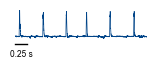

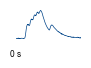

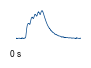

In [91]:
# load data and plot a chunk of data showing a few bursts
data_folder = mosquito_female_folder
axo_num = mosquito_female_axo 
time_range = (78.35, 79.95 + 1.2)  # (79.35, 79.95)
time_start_in1 = 78.42
time_start_in2 = 79.843
window_length = 0.05
time_range_in1 =  (time_start_in1, time_start_in1 + window_length)  # (79.395, 79.475)
time_range_in2 =  (time_start_in2, time_start_in2 + window_length)  # (79.395, 79.475)
data_key = 'emg'

# load data
data = load_processed_data(data_folder, axo_num)

# make figure
fig, ax = plt.subplots(figsize=figsize)
ax = plot_data_trace(data, data_key, time_range, ax=ax, scalebar_size=scalebar_size, line_color=mosquito_female_color)

# also make inset figures
fig_in1, ax_in1 = plt.subplots(figsize=figsize_in)
ax_in1 = plot_data_trace(data, data_key, time_range_in1, ax=ax_in1, scalebar_size=0, line_color=mosquito_female_color)

fig_in2, ax_in2 = plt.subplots(figsize=figsize_in)
ax_in2 = plot_data_trace(data, data_key, time_range_in2, ax=ax_in2, scalebar_size=0, line_color=mosquito_female_color)

# save?
if save_flag:
    # make the filename of the figure reflect which data file it's from
    save_filename = f'{save_str}_{data_folder}_{axo_num:02d}{save_ext}'
    # save
    fig.savefig(os.path.join(save_path, save_filename), dpi=save_dpi, bbox_inches='tight')

    # make the filename of the figure reflect which data file it's from
    save_filename_in1 = f'{save_str_in}1_{data_folder}_{axo_num:02d}{save_ext}'
    # save
    fig_in1.savefig(os.path.join(save_path, save_filename_in1), dpi=save_dpi, bbox_inches='tight')

    # make the filename of the figure reflect which data file it's from
    save_filename_in2 = f'{save_str_in}2_{data_folder}_{axo_num:02d}{save_ext}'
    # save
    fig_in2.savefig(os.path.join(save_path, save_filename_in2), dpi=save_dpi, bbox_inches='tight')

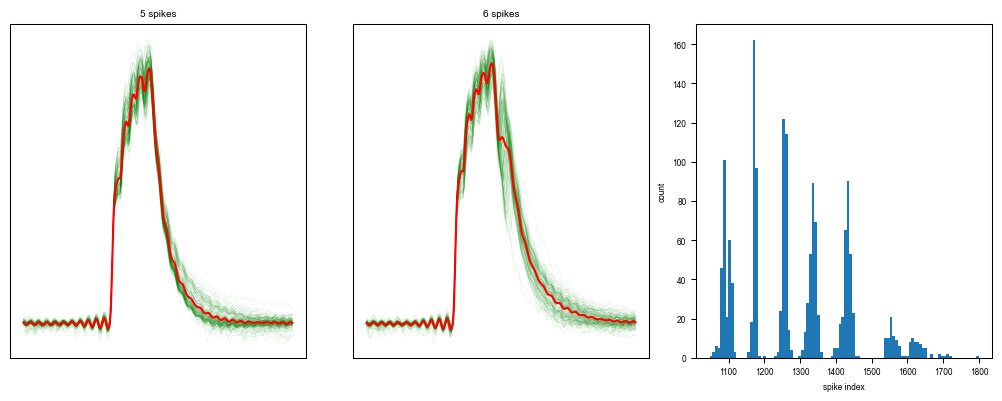

In [92]:
# try detecting spikes for current data file
spikes_df = run_spike_detection(data, viz_flag=True)

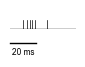

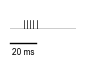

In [93]:
# make accompanying plots of putative motor neuron activity
spike_idx_all = spikes_df['peak_idx_global'].values

fig_burst1, ax_burst1 = plt.subplots(figsize=figsize_in_mn)
ax_burst1 = make_burst_spike_figure(ax_burst1, data['time'], time_range_in1, 
                                    spike_idx_all, line_width=mn_fig_linewidth,
                                    line_color='k', line_height=0.5, 
                                    scalebar_size=scalebar_size_in)

fig_burst2, ax_burst2 = plt.subplots(figsize=figsize_in_mn)
ax_burst2 = make_burst_spike_figure(ax_burst2, data['time'], time_range_in2, 
                                    spike_idx_all, line_width=mn_fig_linewidth,
                                    line_color='k', line_height=0.5, 
                                    scalebar_size=scalebar_size_in)

if save_flag:
    # make the filename of the figure reflect which data file it's from
    save_filename_in1 = f'{save_str_in_mn}1_{data_folder}_{axo_num:02d}{save_ext}'
    # save
    fig_burst1.savefig(os.path.join(save_path, save_filename_in1), dpi=save_dpi, bbox_inches='tight')

    # make the filename of the figure reflect which data file it's from
    save_filename_in2 = f'{save_str_in_mn}2_{data_folder}_{axo_num:02d}{save_ext}'
    # save
    fig_burst2.savefig(os.path.join(save_path, save_filename_in2), dpi=save_dpi, bbox_inches='tight')

## Do a similar set of plots for Drosophila

In [94]:
79.90 - 0.08 + 0.02

79.84

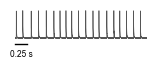

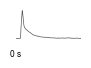

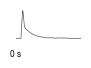

In [98]:
data_folder = drosophila_folder
axo_num = drosophila_axo 
time_range = (78.35, 79.95 + 1.2)  # (79.35, 79.95)
time_start_in1 = 78.50
time_start_in2 = 79.838
window_length = 0.05
time_range_in1 =  (time_start_in1, time_start_in1 + window_length)  # (79.395, 79.475)
time_range_in2 =  (time_start_in2, time_start_in2 + window_length)  # (79.395, 79.475)

# load data
data = load_processed_data(data_folder, axo_num)

# make figure
fig, ax = plt.subplots(figsize=figsize)
ax = plot_data_trace(data, data_key, time_range, ax=ax, scalebar_size=scalebar_size, line_color=drosophila_color)

# also make inset figures
fig_in1, ax_in1 = plt.subplots(figsize=figsize_in)
ax_in1 = plot_data_trace(data, data_key, time_range_in1, ax=ax_in1, scalebar_size=0, line_color=drosophila_color)

fig_in2, ax_in2 = plt.subplots(figsize=figsize_in)
ax_in2 = plot_data_trace(data, data_key, time_range_in2, ax=ax_in2, scalebar_size=0, line_color=drosophila_color)

# save?
if save_flag:
    # make the filename of the figure reflect which data file it's from
    save_filename = f'{save_str}_{data_folder}_{axo_num:02d}{save_ext}'
    # save
    fig.savefig(os.path.join(save_path, save_filename), dpi=save_dpi, bbox_inches='tight')

    # make the filename of the figure reflect which data file it's from
    save_filename_in1 = f'{save_str_in}1_{data_folder}_{axo_num:02d}{save_ext}'
    # save
    fig_in1.savefig(os.path.join(save_path, save_filename_in1), dpi=save_dpi, bbox_inches='tight')

    # make the filename of the figure reflect which data file it's from
    save_filename_in2 = f'{save_str_in}2_{data_folder}_{axo_num:02d}{save_ext}'
    # save
    fig_in2.savefig(os.path.join(save_path, save_filename_in2), dpi=save_dpi, bbox_inches='tight')

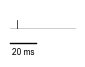

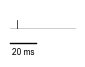

In [99]:
# make accompanying plots of putative motor neuron activity
spike_idx_all = data['spike_idx']

fig_burst1, ax_burst1 = plt.subplots(figsize=figsize_in_mn)
ax_burst1 = make_burst_spike_figure(ax_burst1, data['time'], time_range_in1, 
                                    spike_idx_all, line_width=mn_fig_linewidth, 
                                    line_color='k', line_height=0.5, 
                                    scalebar_size=scalebar_size_in)

fig_burst2, ax_burst2 = plt.subplots(figsize=figsize_in_mn)
ax_burst2 = make_burst_spike_figure(ax_burst2, data['time'], time_range_in2,
                                    spike_idx_all, line_width=mn_fig_linewidth,
                                    line_color='k', line_height=0.5, 
                                    scalebar_size=scalebar_size_in)

if save_flag:
    # make the filename of the figure reflect which data file it's from
    save_filename_in1 = f'{save_str_in_mn}1_{data_folder}_{axo_num:02d}{save_ext}'
    # save
    fig_burst1.savefig(os.path.join(save_path, save_filename_in1), dpi=save_dpi, bbox_inches='tight')

    # make the filename of the figure reflect which data file it's from
    save_filename_in2 = f'{save_str_in_mn}2_{data_folder}_{axo_num:02d}{save_ext}'
    # save
    fig_burst2.savefig(os.path.join(save_path, save_filename_in2), dpi=save_dpi, bbox_inches='tight')

## Make plot showing number of spikes per burst

In [70]:
# dictionary containing spike per burst info
data_path = '/media/sam/SamData/Mosquitoes/analysis'
data_fn = 'burst_analysis_dict.pkl'
data_path_full = os.path.join(data_path, data_fn)

burst_dict = pickle.load(open(data_path_full, "rb"))


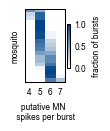

In [74]:
# initialize figure
fig, ax = plt.subplots(figsize=figsize_spike_num)

# temp -- try to make custom colormap
from matplotlib.colors import LinearSegmentedColormap

colors = [(1, 1, 1), mosquito_female_color] # first color is black, last is red
cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=20)

# loop over flies and construct a matrix for this
spike_nums_all_unique = np.unique(np.concatenate(burst_dict['spike_nums']))
spike_nums_all_unique = spike_nums_all_unique[~np.isnan(spike_nums_all_unique)]
n_cols = spike_nums_all_unique.size
n_rows = len(burst_dict['expr_num'])
spike_count_mat = np.zeros((n_rows, n_cols) )

for ith in range(n_rows):
    # read out spike numbers and counts
    spike_nums = burst_dict['spike_nums'][ith]
    spike_num_counts = burst_dict['spike_num_counts'][ith]

    # remove any nan entries
    nan_ind = np.isnan(spike_nums)
    spike_nums = spike_nums[~nan_ind]
    spike_num_counts = spike_num_counts[~nan_ind]
    
    # normalize
    spike_num_counts_norm = spike_num_counts/np.sum(spike_num_counts)

    # put this into matrix
    col_inds = spike_nums - np.min(spike_nums_all_unique)
    col_inds = [int(ind) for ind in col_inds]
    
    # add to matrix
    spike_count_mat[ith, col_inds] = spike_num_counts_norm

# sort heatmap
# spike_count_mat_sort = cluster_matrix_dim(spike_count_mat)
weighted_sum = np.dot(spike_count_mat, spike_nums_all_unique)
sort_idx = np.argsort(weighted_sum)
spike_count_mat_sort = spike_count_mat[sort_idx, :]

# p = ax.imshow(spike_count_mat_sort, interpolation='none', cmap='cividis', aspect='auto')
p = ax.imshow(spike_count_mat_sort, interpolation='none', cmap=cm, aspect='auto')

ax.set_yticks([])
ax.set_xticks(np.arange(n_cols))
ax.set_xticklabels([int(sn) for sn in spike_nums_all_unique]) ;
ax.set_xlabel('putative MN \n spikes per burst')
ax.set_ylabel('mosquito')
ax.tick_params(length=0)

# colorbar
cbar = fig.colorbar(p, shrink=0.6, ax=ax)
cbar.set_label('fraction of bursts')
cbar.ax.tick_params(length=0)

# save output
if save_flag:
    save_filename = 'spike_num_heatmap.svg'
    # save
    fig.savefig(os.path.join(save_path, save_filename), dpi=save_dpi, bbox_inches='tight')

In [208]:
# # take just muscles of a certain type?
# muscle_targets = burst_dict['muscle_target']
# dvm_idx = np.where(np.asarray(muscle_targets) == 'DVM')[0]

# plt.imshow(spike_count_mat[dvm_idx,:], interpolation='none', cmap=cm, aspect='auto')


In [209]:
# dlm_idx = np.where(np.asarray(muscle_targets) == 'DLM')[0]
# plt.imshow(spike_count_mat[dlm_idx,:], interpolation='none', cmap=cm, aspect='auto')


## Make plot showing number spike timing relative to burst onset

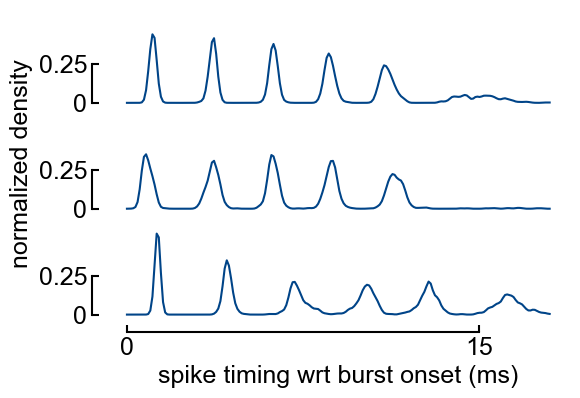

In [286]:
# get spike timing data for a set of flies
ex_flies = [5, 10, 12]
t_range = np.linspace(0, 18, 200)

# initialize figure and axis
fig, ax_list = plt.subplots(len(ex_flies), 1, figsize=(6,4), sharex=True)
fig.subplots_adjust(hspace=0.1, wspace=0.05)
ax_list = ax_list.ravel()

# loop over example flies
for ith, fly in enumerate(ex_flies):
    # read out data for current fly
    spike_times = burst_dict['peak_times'][fly]
    spike_times_ms = 1000*spike_times

    # do KDE
    kde = KernelDensity(kernel="gaussian", bandwidth=0.1).fit(spike_times_ms.reshape(-1, 1))
    log_dens = kde.score_samples(t_range.reshape(-1, 1))
    ax_list[ith].plot(t_range, np.exp(log_dens), color=mosquito_female_color, lw=1.5)

    # set y limits
    ax_list[ith].set_ylim([-0.02, 0.6])
    ax_list[ith].set_yticks([0, 0.25])
    ax_list[ith].set_yticklabels([0, 0.25])
    if ith == 1:
        ax_list[ith].set_ylabel('normalized density')
    
    # adjust axes depending on which row plot is in
    if ith == (len(ex_flies)-1):
        ax_list[ith].set_xticks([0, 15])
        ax_list[ith] = my_adjust_axes(ax_list[ith], offset_length=10)
        ax_list[ith].set_xlabel('spike timing wrt burst onset (ms)')
        
    else:
        ax_list[ith] = my_adjust_axes(ax_list[ith], keep_spines=['left'])
        ax_list[ith].tick_params(axis='x', length=0)

# save result
if save_flag:
    save_filename = 'example_spike_timing.svg'
    # save
    fig.savefig(os.path.join(save_path, save_filename), dpi=save_dpi, bbox_inches='tight')

## Plot spike frequencies within bursts

<ErrorbarContainer object of 3 artists>

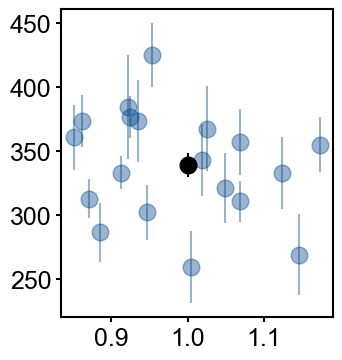

In [294]:
# gather data
spike_freqs_mean = np.asarray([np.nanmean(freqs) for freqs in burst_dict['spike_freqs']])
spike_freqs_std = np.asarray([np.nanstd(freqs) for freqs in burst_dict['spike_freqs']])

# make figure
# initialize figure
fig, ax = plt.subplots(figsize=(3.5, 4))

# plot data
jitter_vals = 0.35*(np.random.rand(spike_freqs_mean.shape[0]) - 0.5)
ax.errorbar(np.ones_like(spike_freqs_mean) + jitter_vals, spike_freqs_mean, 
            yerr=spike_freqs_std, 
            ms=ms, 
            alpha=0.4, 
            color=mosquito_female_color,
            fmt='o')

    # plot mean +/- std
spike_freqs_grand_mean = np.mean(spike_freqs_mean)
spike_freqs_grand_std = np.std(spike_freqs_mean)
spike_freqs_grand_se = spike_freqs_grand_std/np.sqrt(spike_freqs_mean.size)

ax.errorbar(1, spike_freqs_grand_mean, yerr=spike_freqs_grand_se, ecolor='k', fmt='o', color='k', ms=ms)


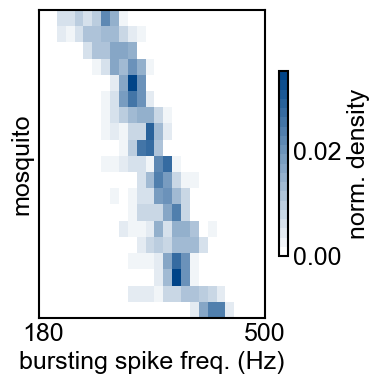

In [333]:
# try this plot as a heatmap
n_edges = 26
fmin = 180
fmax = 500
freq_edges = np.linspace(fmin, fmax, n_edges)

# get data into matrix form
n_rows = len(burst_dict['expr_num'])
n_cols = n_edges - 1
spike_freq_mat = np.zeros((n_rows, n_cols))

for ith in range(n_rows):
    counts_norm, _ = np.histogram(burst_dict['spike_freqs'][ith], bins=freq_edges, density=True)
    spike_freq_mat[ith,:] = counts_norm
    # spike_freqs = burst_dict['spike_freqs'][ith]
    # kde = KernelDensity(kernel="gaussian", bandwidth=4).fit(spike_freqs.reshape(-1, 1))
    # log_dens = kde.score_samples(freq_edges.reshape(-1, 1))
    # spike_freq_mat[ith, :] = np.exp(log_dens)

# make figure
fig, ax = plt.subplots(figsize=figsize_spike_num)

# plot heatmap
# spike_freq_mat_sort = cluster_matrix_dim(spike_freq_mat)
weighted_sum = np.dot(spike_freq_mat, np.linspace(0, 500, n_cols))
sort_idx = np.argsort(weighted_sum)
spike_freq_mat_sort = spike_freq_mat[sort_idx, :]

p = ax.imshow(spike_freq_mat_sort, interpolation='none', cmap=cm, aspect='auto')

ax.set_yticks([])
ax.set_xticks([0, n_cols])
ax.set_xticklabels([int(freq_edges[jth]) for jth in [0, -1]]) ;
# ax.xaxis.set_label_position('top') 
# ax.xaxis.set_ticks_position('top')
ax.set_xlabel('bursting spike freq. (Hz)')
ax.set_ylabel('mosquito')
ax.tick_params(length=0)

# colorbar
cbar = fig.colorbar(p, shrink=0.6, ax=ax)
cbar.set_label('norm. density')
cbar.ax.tick_params(length=0)

# save output
if save_flag:
    save_filename = 'spike_freq_heatmap.svg'
    # save
    fig.savefig(os.path.join(save_path, save_filename), dpi=save_dpi, bbox_inches='tight')

## Plots of spike number and wbf

In [ ]:
#  # get info on current fly 
#     species = burst_dict['species'][ith].lower()
#     sex = burst_dict['sex'][ith].lower()

#     if (species == 'aedes') & (sex == 'f'):
#         color = mosquito_female_color
#     elif (species == 'aedes') & (sex == 'm'):
#         color = mosquito_male_color
#     elif species == 'drosophila':
#         color = drosophila_color
#     else:
#         color = 'k'

#     # plot 
#     ax.plot(spike_nums, spike_num_counts_norm, 'o-', color=color, ms=ms, alpha=0.5)

# ax.set_yscale('log')